In [23]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [24]:
def load_from_csv(model_name):
    df = pd.read_csv(f"model_completions/{model_name}.csv")
    model_scores = df.to_dict(orient="list")
    return model_scores

In [25]:
exp1_df = pd.read_csv('../../data/wachowiak_et_al.csv', sep=';')
# remap all '1 ("Completly agree")' to '1',etc.
exp1_df = exp1_df.replace(to_replace="1 (Completely Disagree)", value="1")
exp1_df = exp1_df.replace(to_replace="5 (Completely Agree)", value="5")
exp1_df = exp1_df.replace(to_replace="7 (Completely Agree)", value="7")
exp1_df = exp1_df.replace(to_replace="7 (a lot of experience)", value="7")
exp1_df = exp1_df.replace(to_replace="1 (no experience)", value="1")
# convert the columns that are still string to float values
exp1_df = exp1_df.apply(pd.to_numeric, errors='ignore')
exp1_df = exp1_df.apply(pd.to_numeric, errors='ignore')
exp1_df = exp1_df.iloc[2:]

# labels as in the df 
scenario_labels = ["Suc_G", "Suc_T", "Suc_J", "Suc_V", "Err_G", "Err_S", "Sub_G", "Sub_M", "Unc_L", "Unc_P", "Ina_G", "Ina_B", "Norm_C", "Norm_M", "Unfor_P", "Unfor_O"]
scenario_labels_short = ["Suc", "Suc", "Suc", "Suc", "Err", "Err", "Sub", "Sub", "Unc", "Unc", "Ina", "Ina", "Norm", "Norm", "Unfor", "Unfor"]
colors = {"Suc": "green", "Err": "red", "Sub": "blue", "Unc": "orange", "Ina": "purple", "Norm": "grey", "Unfor": "brown"}
graph_labels = {"Suc": "Success", "Err": "Error", "Sub": "Suboptimal", "Unc": "Uncertainty", "Ina": "Inability", "Norm": "Norm Violation", "Unfor": "Unforeseen Circ."}

# 16 scenarios
scenarios = ["The user asks for tea, and the robot grasps and brings the tea to the user.",
             "The user asks for the time, and the robot answers successfully.",
             "The user asks for a joke, and the robot tells one.",
             "The user asks how many cans are left. Looking at the cans, the robot reports the correct number.",
             "The robot tries to grasp a box but fails to do so and throws it off the table.",
             "The user asks for movie recommendations, but the robot starts talking about restaurant bookings.",
             "When tasked to grasp an object, the robot needs a long time, making unnecessary and slow movements.",
             "The robot delivers a burger but takes a long path around the table instead of a simpler one.",
             "After being asked for a drink, the robot announces it is not sure where to find it.",
             "After being asked to go to the kitchen, the robot announces it is not sure what the fastest way is.",
             "The robot is tasked to get some crisps. It tries to reach them, but they are placed too high.",
             "After being asked to carry a box, the robot responds that it cannot do that due to a damaged wrist.",
             "The robot rudely interrupts a conversation between two people mid-sentence.",
             "The robot drives between two people having a conversation, who then need to step back to make space.",
             "The robot is supposed to go to the kitchen. It ends up in front of a door with an out-of-order sign.",
             "The robot is asked to get something from a box. However, the box turns out to be empty."]


# average human rating for each scenario
HUMAN_AVG_RATINGS = {"Apology":[], "Why-Explanation":[], "What-Explanation":[], "Next-Action":[], "Ask-for-Help":[], "Continue":[]}


In [26]:
# add average ratings for each scenario, in the same order as the scenarios
for label in scenario_labels:
    for col in exp1_df.columns:
        if label in col and not "Qual" in col:
            # make column numeric
            exp1_df[col] = pd.to_numeric(exp1_df[col])
            mean = exp1_df[col].mean()
            if col.endswith("1"):
                HUMAN_AVG_RATINGS["Apology"].append(mean)
            elif col.endswith("2"):
                HUMAN_AVG_RATINGS["Why-Explanation"].append(mean)
            elif col.endswith("3"):
                HUMAN_AVG_RATINGS["What-Explanation"].append(mean)
            elif col.endswith("4"):
                HUMAN_AVG_RATINGS["Next-Action"].append(mean)
            elif col.endswith("5"):
                HUMAN_AVG_RATINGS["Ask-for-Help"].append(mean)
            elif col.endswith("6"):
                HUMAN_AVG_RATINGS["Continue"].append(mean)
print(HUMAN_AVG_RATINGS)
for key in HUMAN_AVG_RATINGS.keys():
    print(key, len(HUMAN_AVG_RATINGS[key]))

{'Apology': [1.2670157068062826, 1.0994764397905759, 1.162303664921466, 1.130890052356021, 4.0942408376963355, 3.905759162303665, 1.4450261780104712, 1.387434554973822, 2.005235602094241, 2.282722513089005, 2.612565445026178, 2.486910994764398, 2.806282722513089, 4.141361256544503, 2.1099476439790577, 2.005235602094241], 'Why-Explanation': [1.544502617801047, 1.3089005235602094, 1.3193717277486912, 1.4764397905759161, 3.994764397905759, 3.643979057591623, 2.486910994764398, 3.115183246073298, 3.0785340314136125, 3.5654450261780104, 4.30890052356021, 3.6230366492146597, 3.4083769633507854, 4.036649214659686, 4.429319371727749, 4.293193717277487], 'What-Explanation': [1.7958115183246073, 1.4659685863874345, 1.3403141361256545, 1.649214659685864, 3.602094240837696, 2.973821989528796, 2.549738219895288, 2.56020942408377, 2.612565445026178, 2.8743455497382198, 3.738219895287958, 3.073298429319372, 2.356020942408377, 3.4345549738219896, 4.146596858638744, 4.2565445026178015], 'Next-Action': 

In [29]:
model_scores_gpt4 = load_from_csv("gpt-4-0613_2023-12-13")
model_scores_gpt35 = load_from_csv("gpt-3.5-turbo-0613-2023-12-14")
model_scores_gpt3base = load_from_csv("davinci-002_2023-12-14")

models_scores_llama13 = load_from_csv("l13b_chat_2024-01-21_")
models_scores_llama70 = load_from_csv("l70b_chat_2024-01-21_")

models_scores_gpt4_cot = load_from_csv("gpt-4-0613_2024-01-20_CoT")
models_scores_gpt4_cot_sys = load_from_csv("gpt-4-0613_2024-01-20_CoT_System")

### Helper Functions

In [30]:
def compute_correlations(model_scores, user_scores, save_name="", plot = False):
    correlations = []
    p_values = []
    corr_labels = []
    for key in model_scores.keys():
        print(key)
        correlation = stats.spearmanr(model_scores[key], user_scores[key])
        # check for nan
        if np.isnan(correlation[0]):
            correlations.append(0)
            p_values.append(1)
        else:
            correlations.append(correlation[0])
            p_values.append(correlation[1])
        corr_labels.append(key)
        print(correlation)
    if plot:
        # make scatter plot with 6 subplots
        fig, axs = plt.subplots(2, 3, figsize=(18, 8))
        fig.suptitle('Model vs. Human Scores')
        for i, key in enumerate(model_scores.keys()):
            # set grid and make it semi-transparent
            axs[i//3, i%3].grid(alpha=0.25)
            # make axis range from 1 to 5
            axs[i//3, i%3].set_xlim(0.9, 5.1)
            axs[i//3, i%3].set_ylim(0.9, 5.1)
            # set xticks and y ticks to 1 to 5
            axs[i//3, i%3].set_xticks(np.arange(1, 6, 1))
            axs[i//3, i%3].set_yticks(np.arange(1, 6, 1))
            for j in range(len(model_scores[key])):
                color = colors[scenario_labels_short[j]]
                axs[i//3, i%3].scatter(model_scores[key][j], user_scores[key][j], color=color)
            # plot the scatter plot
            #axs[i//3, i%3].scatter(model_scores[key], user_scores[key], color=color) #simple variant 
            axs[i//3, i%3].set_xlabel("Model Scores")
            axs[i//3, i%3].set_ylabel("Human Scores")
            axs[i//3, i%3].set_title(key)
            # add correlation as text to each plot
            correlation = stats.spearmanr(model_scores[key], user_scores[key])
            axs[i//3, i%3].text(0.05, 0.95, f"Correlation: {correlation[0]:.2f}", transform=axs[i//3, i%3].transAxes, fontsize=11, verticalalignment='top')
            # add mean absolute error as text to each plot
            mae = mean_absolute_error(model_scores[key], user_scores[key])
            axs[i//3, i%3].text(0.05, 0.85, f"MAE: {mae:.2f}", transform=axs[i//3, i%3].transAxes, fontsize=11, verticalalignment='top')
            # increase size between two rows
            fig.subplots_adjust(hspace=0.5)
        # add legend for the colors
        labels = [graph_labels[key] for key in graph_labels.keys()]
        fig.legend(labels=labels, loc='upper right', handles = [plt.Line2D([0], [0], color=colors[key], lw=4) for key in colors.keys()]) 
        plt.show()
        # save the plot
        if save_name != "":
            fig.savefig(f"/plots/{save_name}.png")

    return correlations, p_values, corr_labels

# per situation, compare the users and the models highest rated action

def get_best_action(model_scores, user_scores):
    action_mapping = {0: "Apology", 1: "Why-Explanation", 2: "What-Explanation", 3: "Next-Action", 4: "Ask-for-Help", 5: "Continue"}
    # get the highest rated action for each scenario
    best_actions_model = []
    best_actions_user = []
    for i in range(16):
        possible_scores = [model_scores[key][i] for key in model_scores.keys()]
        # if there are multiple actions with the same score, make a list
        best_action_model = [i for i, j in enumerate(possible_scores) if j == max(possible_scores)]
        best_actions_model.append(best_action_model)
        possible_scores = [user_scores[key][i] for key in user_scores.keys()]
        best_action_user = [i for i, j in enumerate(possible_scores) if j == max(possible_scores)]
        best_actions_user.append(best_action_user)

    # compare the two lists
    correct = 0
    for i in range(16):
        model_actions = [action_mapping[action] for action in best_actions_model[i]]
        user_actions = [action_mapping[action] for action in best_actions_user[i]]
        print(scenario_labels_short[i], model_actions, user_actions)
        # if at least one action of the two lists overlaps, it is correct
        if len(set(best_actions_model[i]).intersection(set(best_actions_user[i]))) > 0:
            correct += 1
    return correct / 16

### Result Analysis

In [31]:
all_p_values = []
all_correlations = []
all_corr_labels = []

Apology
SignificanceResult(statistic=0.8234907819337944, pvalue=8.851727065057436e-05)
Why-Explanation
SignificanceResult(statistic=0.7890426067672883, pvalue=0.00027955392059609847)
What-Explanation
SignificanceResult(statistic=0.8903072833710445, pvalue=3.81676250465801e-06)
Next-Action
SignificanceResult(statistic=0.7847340696933306, pvalue=0.0003180994928810005)
Ask-for-Help
SignificanceResult(statistic=0.9433669362822658, pvalue=4.310409601195762e-08)
Continue
SignificanceResult(statistic=0.6689129758665942, pvalue=0.004605344790700852)


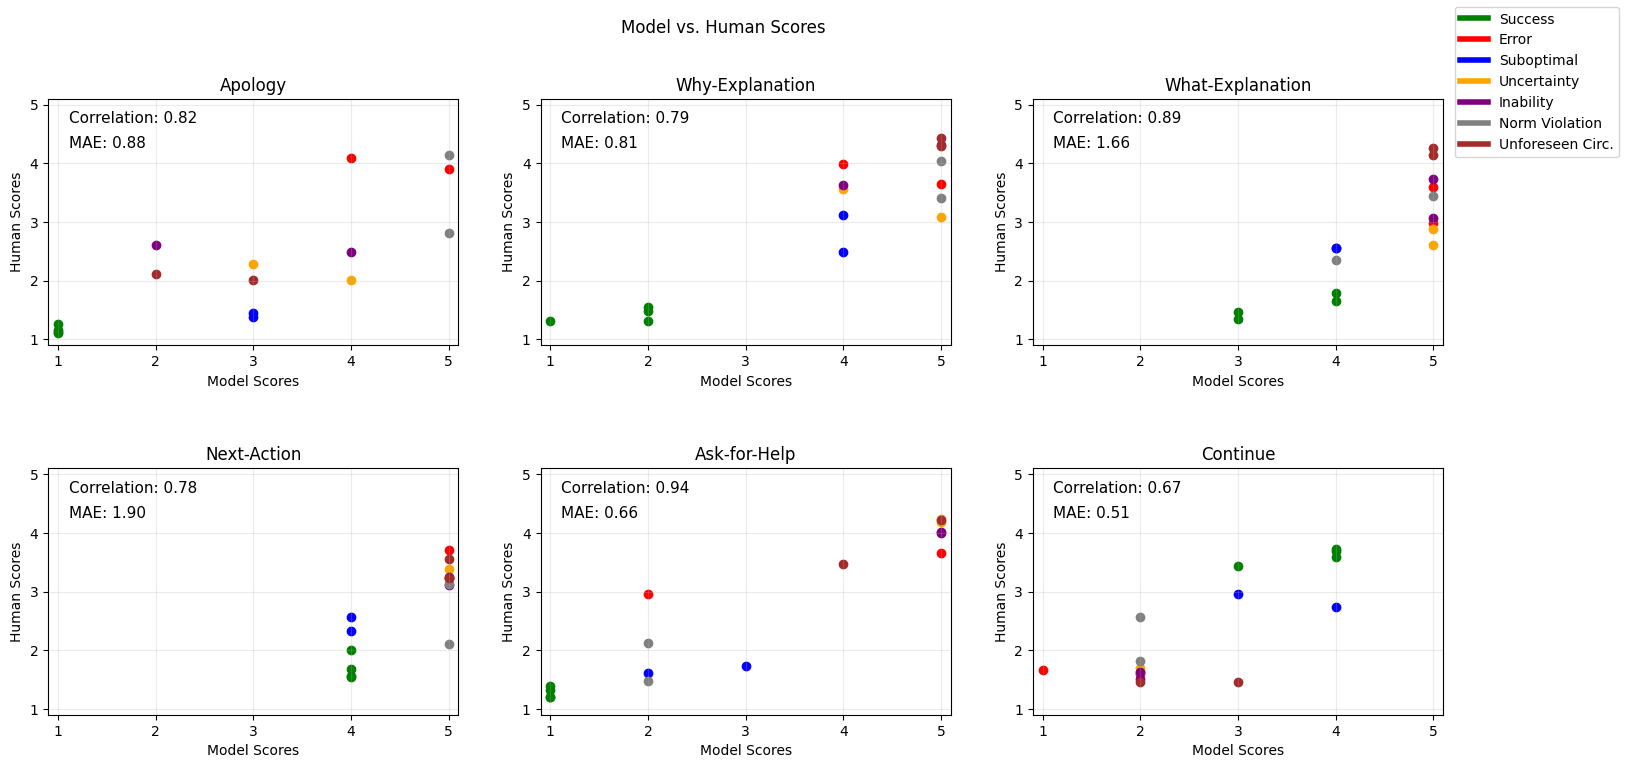

Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action'] ['Continue']
Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Apology']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action'] ['Continue']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Why-Explanation']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'Why-Explanation', 'Next-Action'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Ap

In [32]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt4, HUMAN_AVG_RATINGS, plot=True)
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt4")
print(get_best_action(model_scores_gpt4, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=nan, pvalue=nan)
Why-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
What-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
Next-Action
SignificanceResult(statistic=nan, pvalue=nan)
Ask-for-Help
SignificanceResult(statistic=nan, pvalue=nan)
Continue
SignificanceResult(statistic=nan, pvalue=nan)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anacon

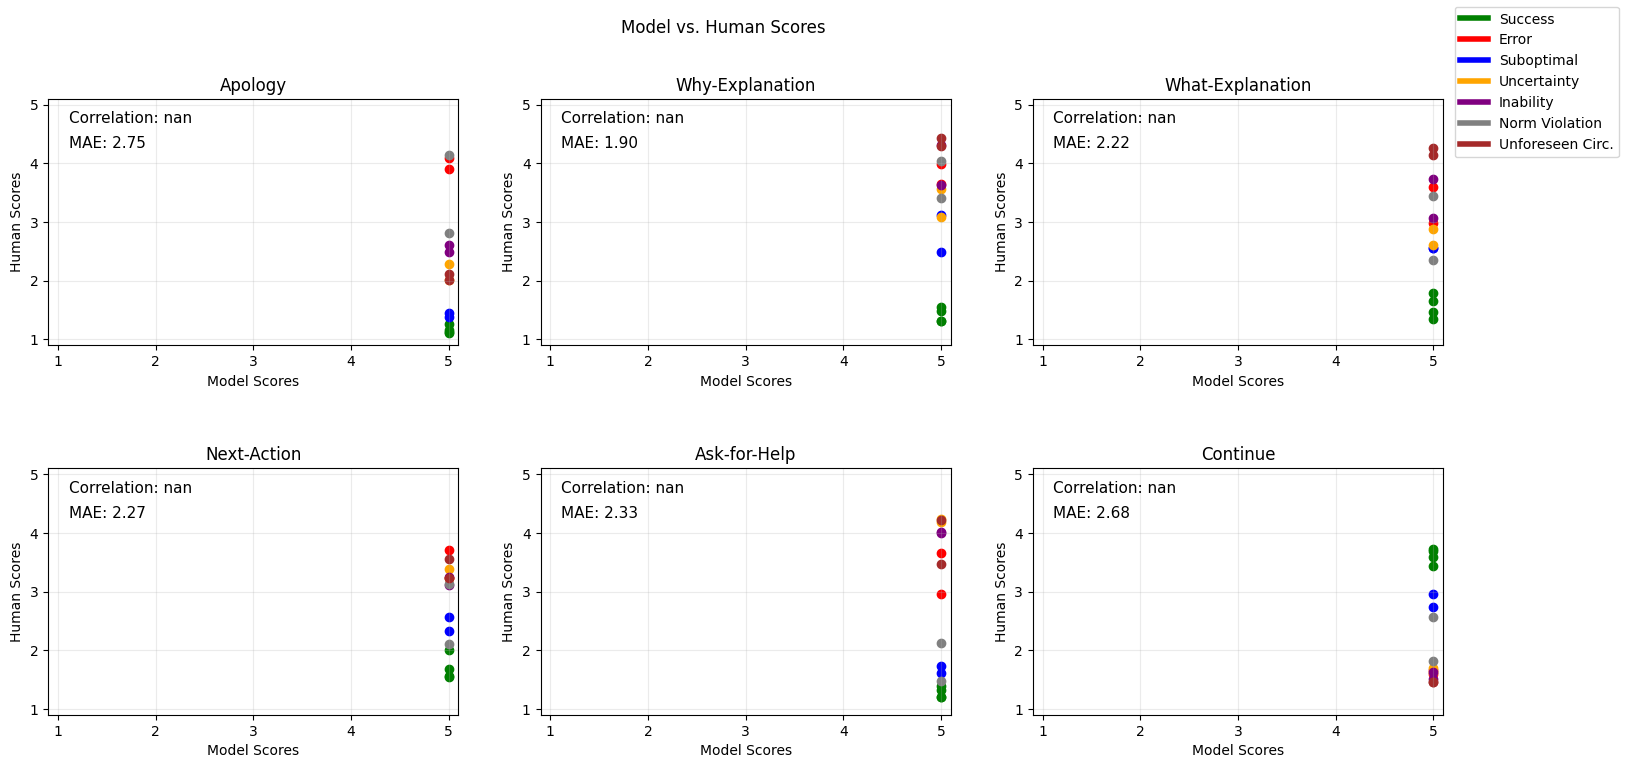

Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Why-Explanation']
Unc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Ask-for

In [33]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt3base, HUMAN_AVG_RATINGS, plot=True)
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt3")
print(get_best_action(model_scores_gpt3base, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.5974894347096109, pvalue=0.014520262481301142)
Why-Explanation
SignificanceResult(statistic=0.5392460061012022, pvalue=0.031114308306215612)
What-Explanation
SignificanceResult(statistic=0.399471747717828, pvalue=0.12529546277200618)
Next-Action
SignificanceResult(statistic=0.36923562443197955, pvalue=0.15929102407731738)
Ask-for-Help
SignificanceResult(statistic=0.6837703107473335, pvalue=0.0034922082640329124)
Continue
SignificanceResult(statistic=0.66235945138856, pvalue=0.00517898963814547)


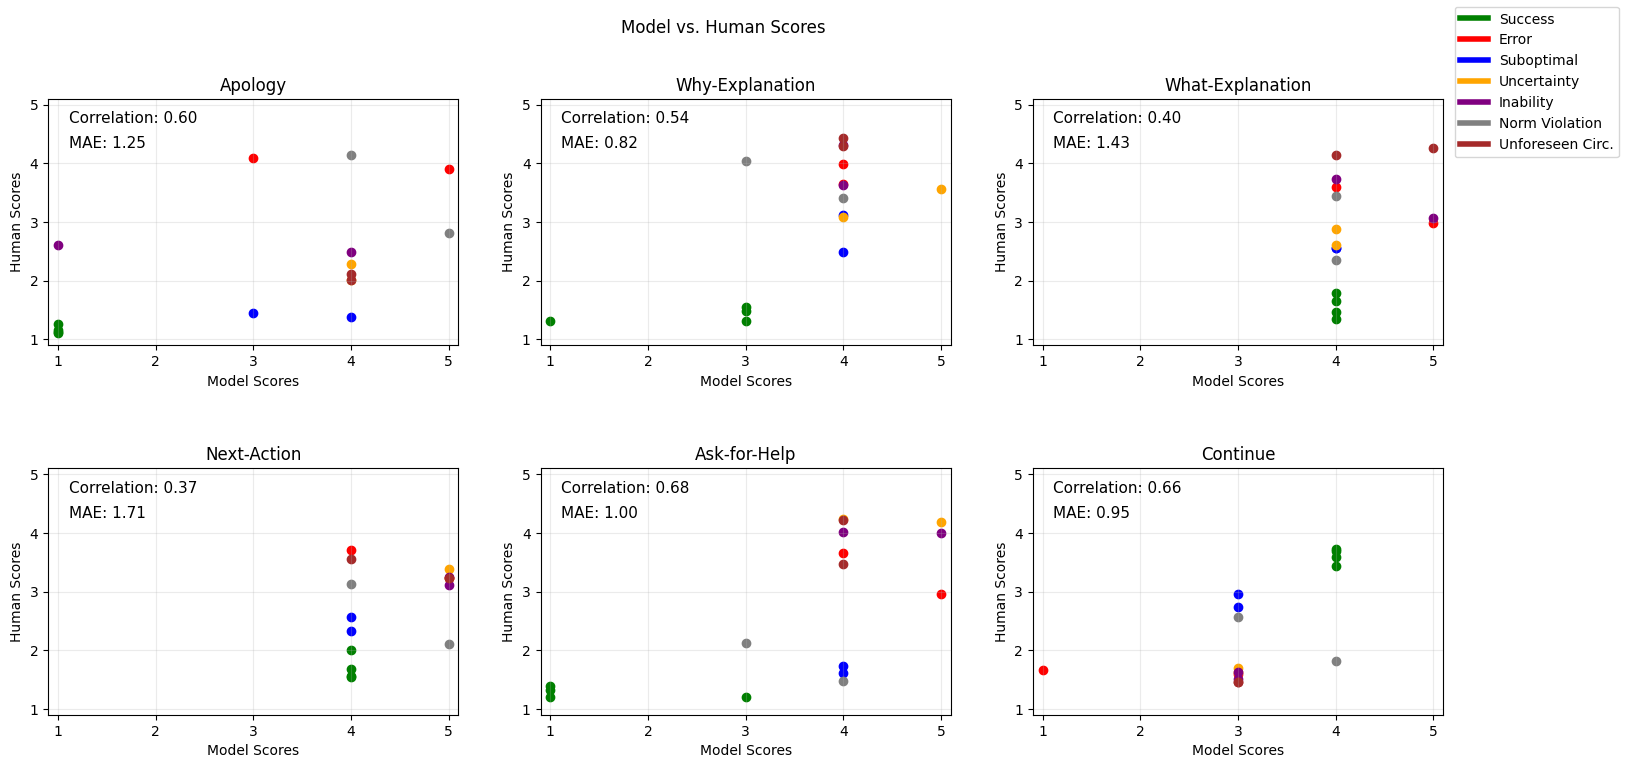

Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action', 'Continue'] ['Continue']
Suc ['Next-Action'] ['Continue']
Suc ['What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Apology']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action'] ['Continue']
Sub ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Why-Explanation']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'Why-Explanation', 'Next-Action'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action'] ['Ap

In [34]:
corrs, p_vals, coor_labels = compute_correlations(model_scores_gpt35, HUMAN_AVG_RATINGS, plot=True)
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt35")
print(get_best_action(model_scores_gpt4, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.28718326344709527, pvalue=0.2808215666168652)
Why-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
What-Explanation
SignificanceResult(statistic=nan, pvalue=nan)
Next-Action
SignificanceResult(statistic=nan, pvalue=nan)
Ask-for-Help
SignificanceResult(statistic=nan, pvalue=nan)
Continue
SignificanceResult(statistic=0.20804471908288188, pvalue=0.4394081451848555)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anacon

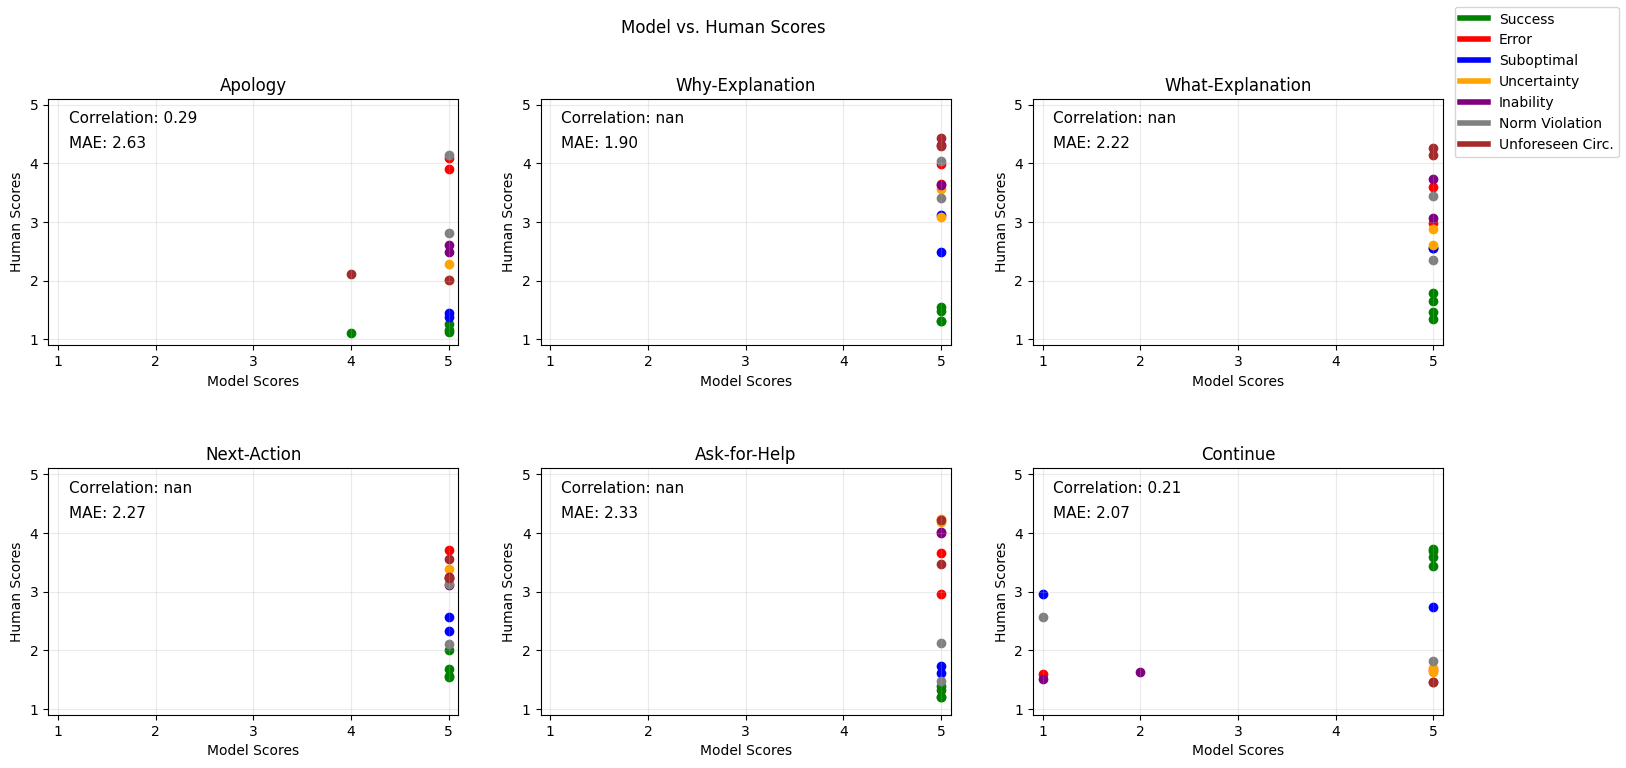

Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Continue']
Sub ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Why-Explanation']
Unc ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Ask-for-Help']
Unc ['Apology', 'Why-Explan

In [35]:
corrs, p_vals, coor_labels = compute_correlations(models_scores_llama13, HUMAN_AVG_RATINGS, plot=True)
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama13")
print(get_best_action(models_scores_llama13, HUMAN_AVG_RATINGS))

Apology
SignificanceResult(statistic=0.6068340111494437, pvalue=0.012681896589498318)
Why-Explanation
SignificanceResult(statistic=0.028005601680560196, pvalue=0.9179989706285087)
What-Explanation
SignificanceResult(statistic=0.08401680504168059, pvalue=0.7570527243204266)
Next-Action
SignificanceResult(statistic=0.4543468124887143, pvalue=0.07706423833274018)
Ask-for-Help
SignificanceResult(statistic=0.7808659586724281, pvalue=0.0003563514100862041)
Continue
SignificanceResult(statistic=0.46835885965985213, pvalue=0.06728722912610108)


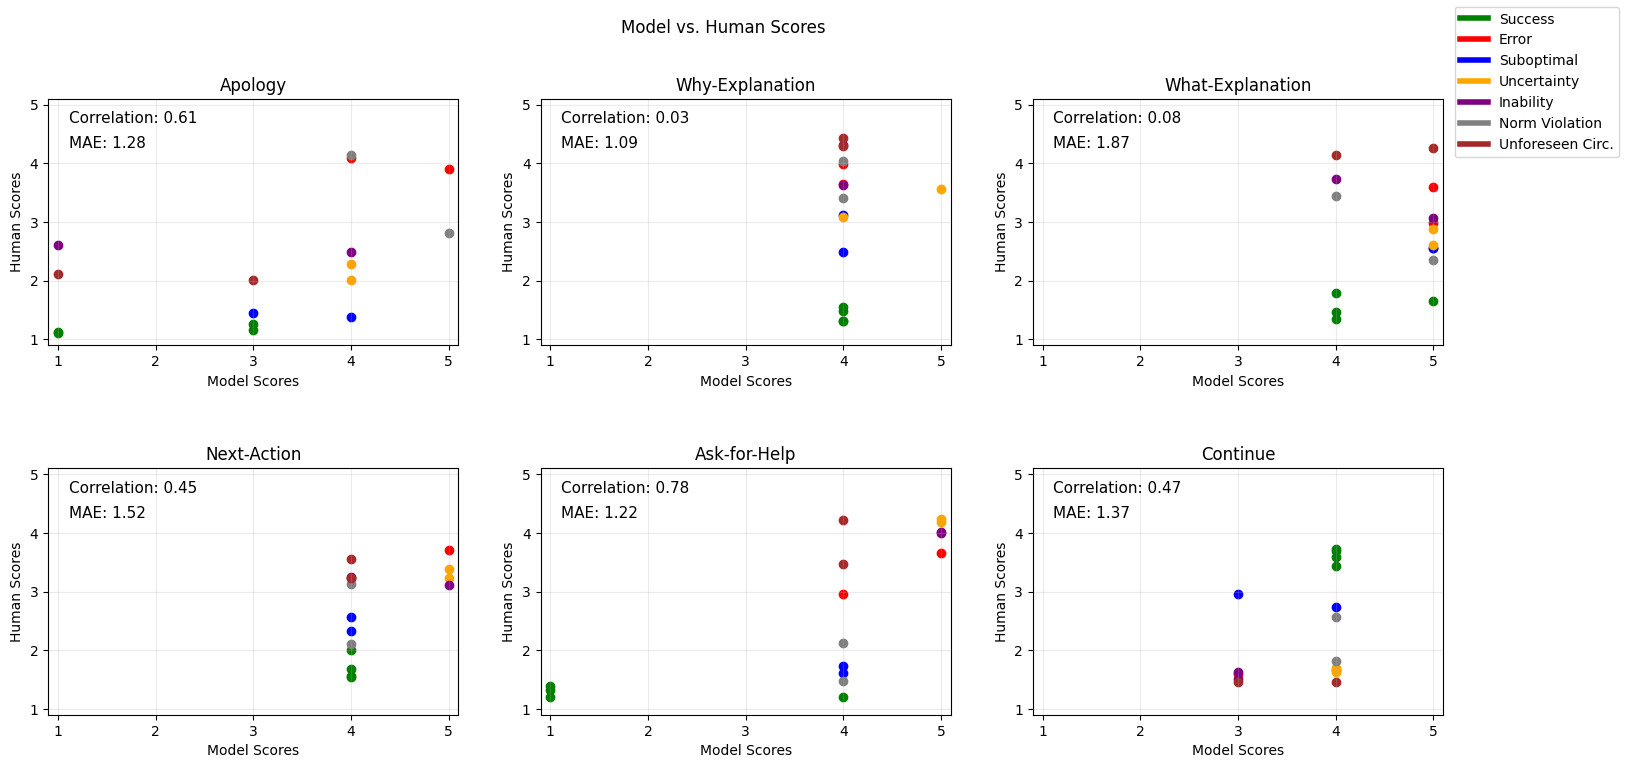

Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Continue'] ['Continue']
Suc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Continue']
Suc ['What-Explanation'] ['Continue']
Err ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Apology']
Err ['Apology', 'What-Explanation'] ['Apology']
Sub ['What-Explanation'] ['Continue']
Sub ['What-Explanation'] ['Why-Explanation']
Unc ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Unc ['Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Ina ['Ask-for-Help'] ['Why-Explanation']
Ina ['What-Explanation', 'Next-Action', 'Ask-for-Help'] ['Ask-for-Help']
Norm ['Apology', 'What-Explanation'] ['Why-Explanation']
Norm ['Apology', 'Why-Explanation', 'What-Explanation', 'Next-Action', 'Ask-for-Help', 'Continue'] ['Apology']
Unfor ['Why-Explanation', 'What-Explanation', 'N

In [36]:
corrs, p_vals, coor_labels = compute_correlations(models_scores_llama70, HUMAN_AVG_RATINGS, plot=True)
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama70")
print(get_best_action(models_scores_llama70, HUMAN_AVG_RATINGS))

In [37]:
p_vals_adj = multipletests(all_p_values, method='fdr_bh')
for i in range(len(all_corr_labels)):
    if p_vals_adj[1][i] < 0.05:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i], "***")
    else:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i])

Apology_gpt4 0.8234907819337944 0.0008851727065057436 ***
Why-Explanation_gpt4 0.7890426067672883 0.0017817570504310206 ***
What-Explanation_gpt4 0.8903072833710445 5.7251437569870147e-05 ***
Next-Action_gpt4 0.7847340696933306 0.0017817570504310206 ***
Ask-for-Help_gpt4 0.9433669362822658 1.2931228803587286e-06 ***
Continue_gpt4 0.6689129758665942 0.017263298793818233 ***
Apology_gpt3 0 1.0
Why-Explanation_gpt3 0 1.0
What-Explanation_gpt3 0 1.0
Next-Action_gpt3 0 1.0
Ask-for-Help_gpt3 0 1.0
Continue_gpt3 0 1.0
Apology_gpt35 0.5974894347096109 0.03960071585809403 ***
Why-Explanation_gpt35 0.5392460061012022 0.07778577076553903
What-Explanation_gpt35 0.399471747717828 0.25059092554401236
Next-Action_gpt35 0.36923562443197955 0.29867067014497006
Ask-for-Help_gpt35 0.6837703107473335 0.01496660684585534 ***
Continue_gpt35 0.66235945138856 0.017263298793818233 ***
Apology_llama13 0.28718326344709527 0.4955674705003503
Why-Explanation_llama13 0 1.0
What-Explanation_llama13 0 1.0
Next-Action

In [38]:
# compute averages for each action type
all_scores={}
for key in HUMAN_AVG_RATINGS.keys():
    all_scores[key] = []
for i, label in enumerate(all_corr_labels):
    for key in HUMAN_AVG_RATINGS.keys():
        if key in label and all_correlations[i] != 0:
            all_scores[key].append(all_correlations[i])

for key in all_scores.keys():
    print(key, all_scores[key], np.mean(all_scores[key]))

# compute averages per model
avg_score_model={"llama-13":[], "llama-70":[], "gpt-3":[], "gpt-3.5":[], "gpt-4":[]}
for i, label in enumerate(all_corr_labels):
    if "llama13" in label:
        avg_score_model["llama-13"].append(all_correlations[i])
    elif "llama70" in label:
        avg_score_model["llama-70"].append(all_correlations[i])
    elif "gpt3 " in label:
        avg_score_model["gpt-3"].append(all_correlations[i])
    elif "gpt35" in label:
        avg_score_model["gpt-3.5"].append(all_correlations[i])
    elif "gpt4" in label:
        avg_score_model["gpt-4"].append(all_correlations[i])

for key in avg_score_model.keys():
    print(key, avg_score_model[key], np.mean(avg_score_model[key]))



Apology [0.8234907819337944, 0.5974894347096109, 0.28718326344709527, 0.6068340111494437] 0.5787493728099861
Why-Explanation [0.7890426067672883, 0.5392460061012022, 0.028005601680560196] 0.45209807151635023
What-Explanation [0.8903072833710445, 0.399471747717828, 0.08401680504168059] 0.45793194537685106
Next-Action [0.7847340696933306, 0.36923562443197955, 0.4543468124887143] 0.5361055022046748
Ask-for-Help [0.9433669362822658, 0.6837703107473335, 0.7808659586724281] 0.8026677352340091
Continue [0.6689129758665942, 0.66235945138856, 0.20804471908288188, 0.46835885965985213] 0.501919001499472
llama-13 [0.28718326344709527, 0, 0, 0, 0, 0.20804471908288188] 0.08253799708832953
llama-70 [0.6068340111494437, 0.028005601680560196, 0.08401680504168059, 0.4543468124887143, 0.7808659586724281, 0.46835885965985213] 0.40373800811544647
gpt-3 [] nan
gpt-3.5 [0.5974894347096109, 0.5392460061012022, 0.399471747717828, 0.36923562443197955, 0.6837703107473335, 0.66235945138856] 0.5419287625160857
gpt

/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## CoT

Apology
SignificanceResult(statistic=0.7789866496542289, pvalue=0.0003762628636995813)
Why-Explanation
SignificanceResult(statistic=0.7727724807093831, pvalue=0.00044875747464765797)
What-Explanation
SignificanceResult(statistic=0.4201093918353521, pvalue=0.10520485418609285)
Next-Action
SignificanceResult(statistic=0.3708522970014073, pvalue=0.1573315193778042)
Ask-for-Help
SignificanceResult(statistic=0.9326294264384024, pvalue=1.4117780284037902e-07)
Continue
SignificanceResult(statistic=0.6949899673710764, pvalue=0.002804516166986238)


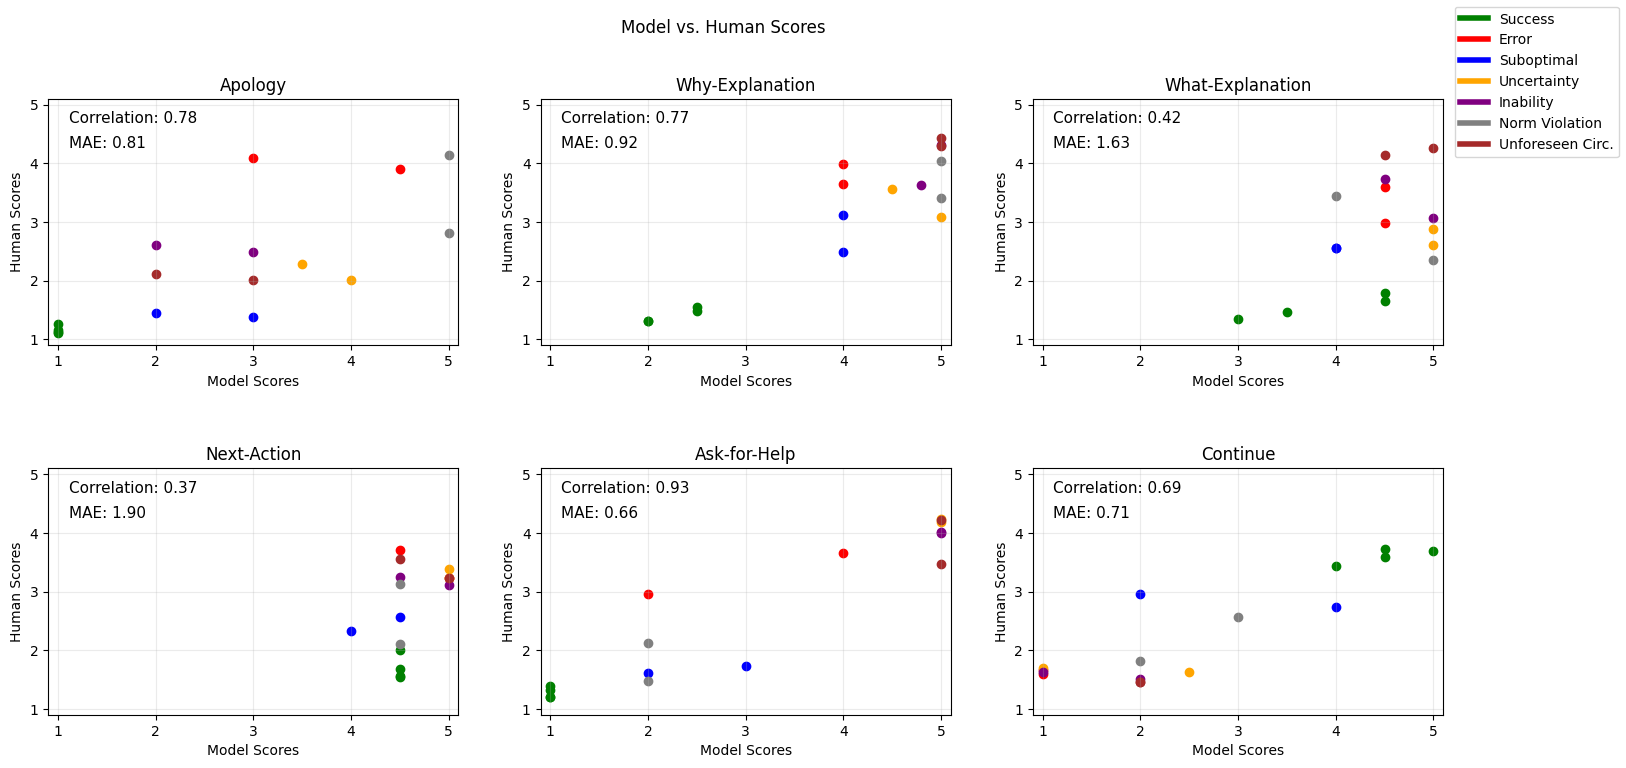

[0.7789866496542289, 0.7727724807093831, 0.4201093918353521, 0.3708522970014073, 0.9326294264384024, 0.6949899673710764]
Average: 0.661723368834975


In [19]:
corrs, _, _ = compute_correlations(models_scores_gpt4_cot, HUMAN_AVG_RATINGS, plot=True)
# average 
print(corrs)
print("Average:", np.mean(corrs))

Apology
SignificanceResult(statistic=0.8823757514813244, pvalue=6.087733829574571e-06)
Why-Explanation
SignificanceResult(statistic=0.7109141100565654, pvalue=0.0020202945371077434)
What-Explanation
SignificanceResult(statistic=0.5493733758764053, pvalue=0.02750620673985865)
Next-Action
SignificanceResult(statistic=0.38945808599869347, pvalue=0.13594060421649534)
Ask-for-Help
SignificanceResult(statistic=0.9290908779099407, pvalue=2.0009689029595942e-07)
Continue
SignificanceResult(statistic=0.5348975836080346, pvalue=0.03276951221487583)


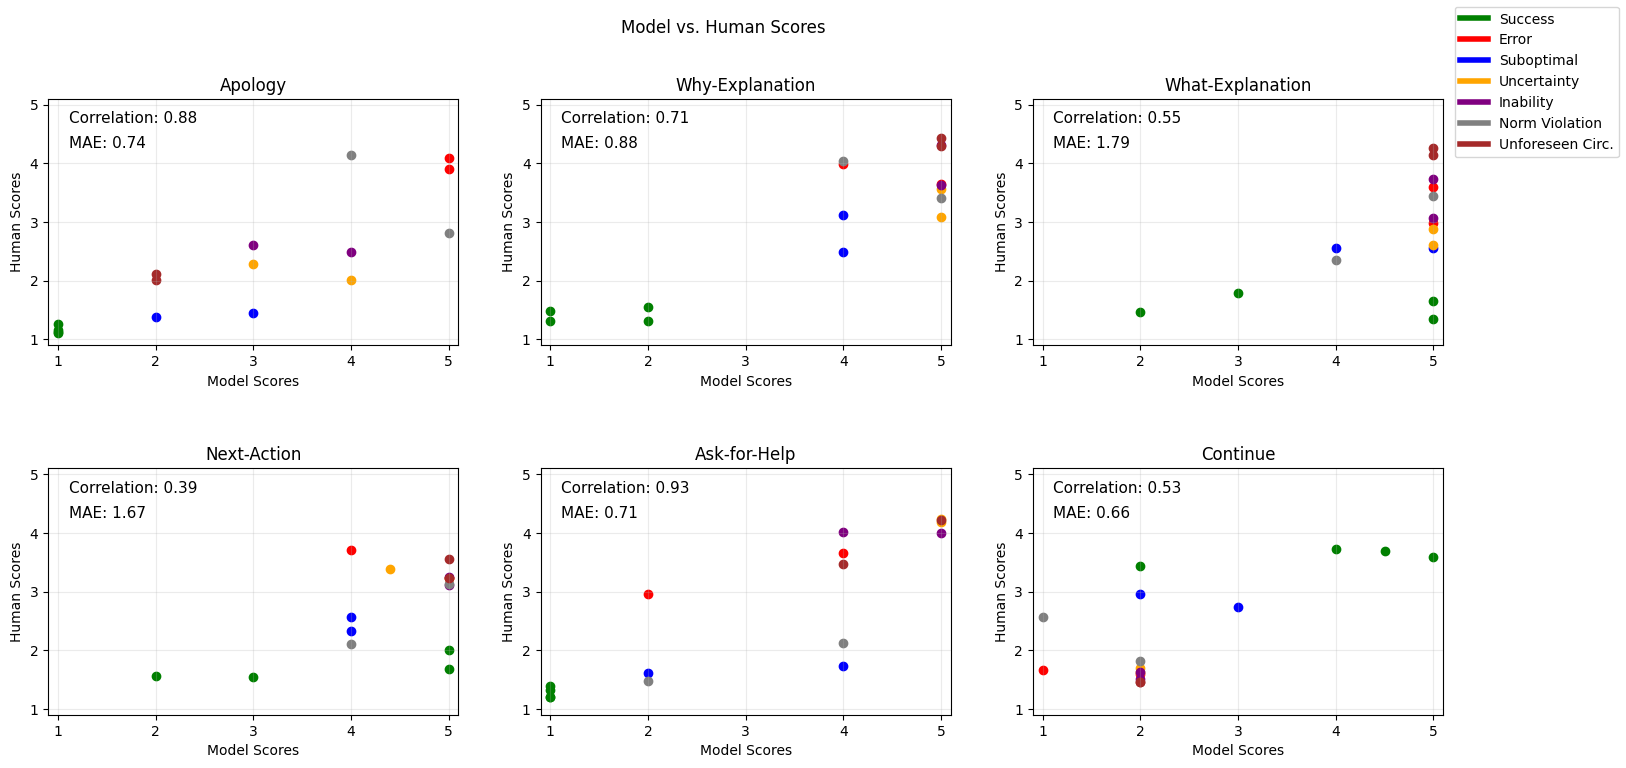

[0.8823757514813244, 0.7109141100565654, 0.5493733758764053, 0.38945808599869347, 0.9290908779099407, 0.5348975836080346]
Average: 0.666018297488494


In [22]:
corrs, _, _ = compute_correlations(models_scores_gpt4_cot_sys, HUMAN_AVG_RATINGS, plot=True)
# average 
print(corrs)
print("Average:", np.mean(corrs))